## Zadanie domowe: BBHE i DSIHE

W klasycznym wyrównywaniu histogramu HE  po wykonaniu operacji jasność obrazu ulega zmianie.
Dało się to zaobserwować podczas przeprowadzonych eksperymentów.
Jeśli nie to należy uruchomić skrypt z sekcji A i zwrócić na to uwagę.
Średnia jasność dąży do środkowego poziomu szarości.
Jest to wada i dlatego klasyczne HE ma ograniczone zastosowanie.

Powstało sporo metod, które eliminują to niekorzystne zjawisko.
Najprostsze z nich polegają na dekompozycji obrazu wejściowego na dwa podobrazy (wg. pewnego kryterium).
Następnie operacja HE wykonywana jest dla tych podobrazów.

Dwie znane z literatury metody to:
- Bi-Histogram Equalization
- DSIHE - Dualistic Sub-Image Histogram Equalization

W metodzie BBHE za kryterium podziału przyjmuje się średnią jasność w obrazie.
W DSIHE obraz dzieli się na dwa podobrazy o takiej samej liczbie pikseli (jaśniejszych i ciemniejszych).

W ramach zadania należy zaimplementować wybraną metodę: BBHE lub DSIHE (ew. obie).

1. Wczytaj obraz *jet.bmp* i wylicz jego histogram.
2. W kolejnym kroku należy wyznaczyć próg podziału obrazu na dwa podobrazy (*lm*).
3. Dla BBHE wyznacz średnią jasność obrazu. Dla DSIHE można wykorzystać histogram skumulowany.
Należy znaleźć poziom jasności który znajduje się "w połowie" histogramu skumulowanego.
W tym celu warto stworzyć tablicę, zawierającą moduł histogramu skumulowanego pomniejszonego o połowę liczby pikseli.
Następnie znaleźć minimum - `np.argmin`.
4. Dalej należy podzielić histogram oryginalnego obrazu na dwa histogramy *H1* i *H2*.
Dla każdego z nich wyliczyć histogram skumulowany ($C_1$ i $C_2$) i wykonać normalizację.
Normalizacja polega na podzieleniu każdego histogramu przez jego największy element.
5. Na podstawie histogramów skumulowanych należy stworzyć przekształcenie LUT.
Należy tak przeskalować $C_1$ i $C_2$, aby uzyskać jednorodne przekształcenie.
Tablicę $C_1$ wystarczy pomnożyć przez próg podziału.
Tablicę $C_2$ należy przeskalować do przedziału: $<lm+1; 255>$, gdzie $lm$ jest progiem podziału.<br>
$C_{1n} = (lm)*C1;$<br>
$C_{2n} = lm+1 + (255-lm-1)*C2;$<br>
Następnie dwie części tablicy przekodowań należy połączyć.
6. Ostatecznie należy wykonać operację LUT i wyświetlić wynik wyrównywania histogramu.
Porównaj wynik operacji BBHE lub DSIHE z klasycznym HE.

In [105]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

URL = "https://raw.githubusercontent.com/vision-agh/poc_sw/master/03_Histogram/"
JET_FILENAME = "jet.bmp"

if not os.path.exists(JET_FILENAME):
    r = requests.get(URL + JET_FILENAME, allow_redirects=True)
    open(JET_FILENAME, "wb").write(r.content)

In [106]:
def show_grayscale_image(
    grayscale_image, ax=plt, mark_value=None, mark_color=(255, 0, 0)
):
    if mark_value is not None:
        marked_part = (grayscale_image == mark_value).astype(np.uint8)
    else:
        marked_part = np.zeros(shape=grayscale_image.shape, dtype=np.uint8)

    rgb_image = cv2.cvtColor(grayscale_image * (1 - marked_part), cv2.COLOR_GRAY2RGB)
    marks = np.zeros(grayscale_image.shape + (3,), dtype=np.uint8)

    for key, value in {0: (0, 0, 0), 1: mark_color}.items():
        marks[marked_part == key] = value

    ax.imshow(rgb_image + marks)

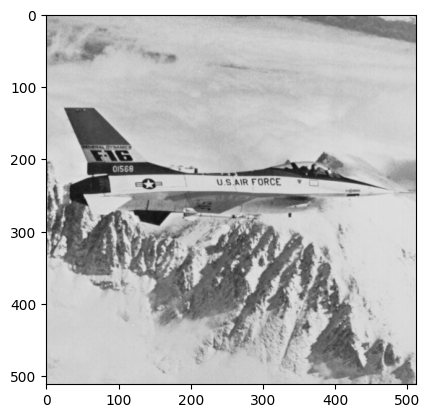

In [107]:
jet_image = cv2.imread(JET_FILENAME)
jet_image = cv2.cvtColor(jet_image, cv2.COLOR_RGB2GRAY)

show_grayscale_image(jet_image)

In [108]:
def find_average(image):
    return np.average(image)


def find_median(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    cum_hist = hist.cumsum()
    cum_hist /= np.max(cum_hist)
    return np.argmin(np.abs(cum_hist - 0.5))

In [109]:
def divide_into_two_images(image, threshold):
    image1 = (image <= threshold).astype(np.uint8) * image
    image2 = (image > threshold).astype(np.uint8) * image

    return image1, image2

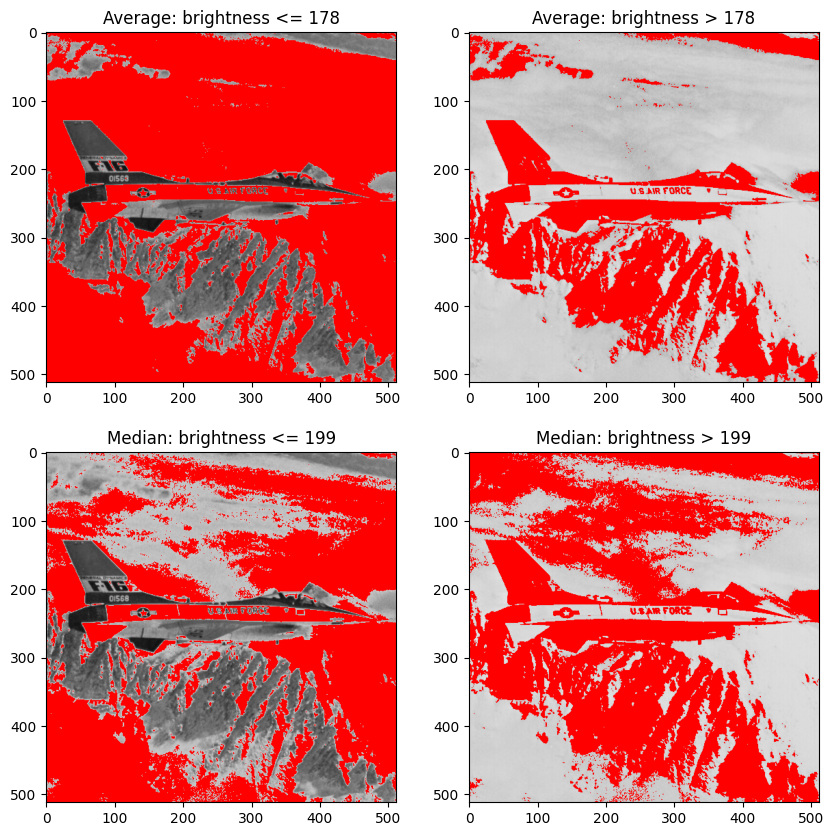

In [110]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

for i, (find_threshold, name) in enumerate(
    [
        (find_average, "Average"),
        (find_median, "Median"),
    ]
):
    threshold = find_threshold(jet_image)
    images = divide_into_two_images(jet_image, threshold)

    for ax, image, title in zip(
        axs[i],
        images,
        [f"{name}: brightness {symbol} {int(threshold)}" for symbol in ["<=", ">"]],
    ):
        ax.set_title(title)
        show_grayscale_image(image, ax, mark_value=0)

In [111]:
def equalize_image(image, threshold):
    threshold = int(threshold)
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    hists = hist[0 : threshold + 1], hist[threshold + 1 : 256]
    cum_hist1, cum_hist2 = [h.cumsum() / np.max(h.cumsum()) for h in hists]

    cum_hist1 *= threshold
    cum_hist2 *= 255 - threshold
    cum_hist2 += threshold + 1
    concatenated_cum_hist = np.concatenate((cum_hist1, cum_hist2)).astype(np.uint8)

    lut = np.array(
        concatenated_cum_hist.astype(np.uint8),
        dtype=np.uint8,
    )
    return cv2.LUT(image, lut)

In [112]:
def BBHE_equalization(image):
    threshold = find_average(image)
    return equalize_image(image, threshold)


def DSIHE_equalization(image):
    threshold = find_median(image)
    return equalize_image(image, threshold)

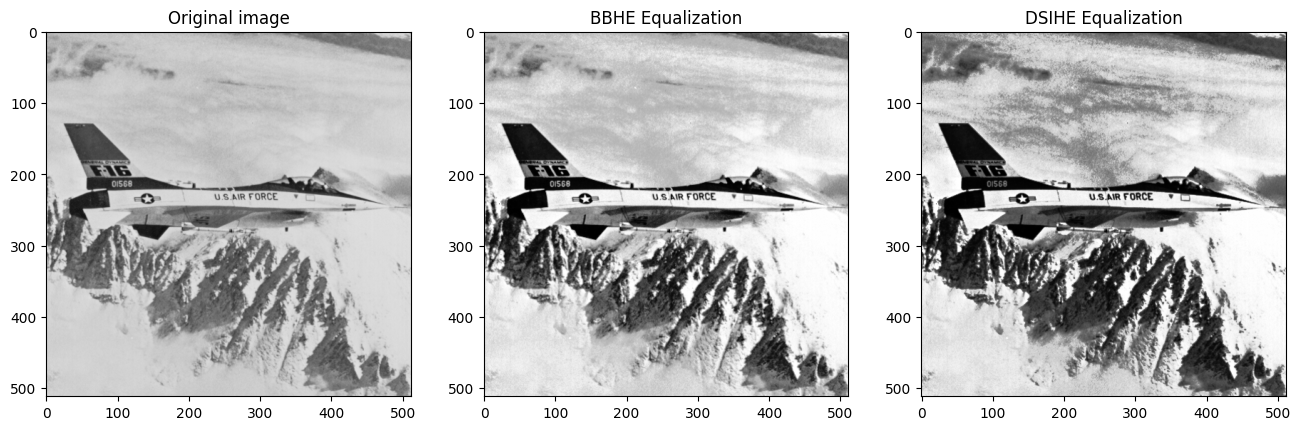

In [113]:
results = [
    ("Original image", jet_image),
    ("BBHE Equalization", BBHE_equalization(jet_image)),
    ("DSIHE Equalization", DSIHE_equalization(jet_image)),
]

fig, axs = plt.subplots(ncols=3, figsize=(16, 6))

for ax, (title, image) in zip(axs, results):
    ax.set_title(title)
    show_grayscale_image(image, ax)